In [3]:
pip install xlrd

Note: you may need to restart the kernel to use updated packages.


In [181]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from factor_analyzer import FactorAnalyzer, Rotator
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo

from scipy import stats 
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

from sklearn.metrics import calinski_harabasz_score
from sklearn.cluster import KMeans

In [182]:
df = pd.read_excel('index2022_data.xls', index_col=0)
df

,CountryName,HighIncome,Income,Development,Region,WorldRank,RegionRank,2022Score,PropertyRights,JudicialEffectiveness,...,GovernmentExpenditurofGDP,Population,GDP,GDP_GrowthRate,5Year_GDP_GrowthRate,GDPperCapita,Unemployment,Inflation,FDIInflow,PublicDebt
CountryID,,,,,,,,,,,,,,,,,,,,,
1,Afghanistan,0,low income,developing,Asia-Pacific,NaN,NaN,NaN,NaN,NaN,...,NaN,38.928341,78.729,-5.000,0.9824,2390.024,11.73,5.607,13.000000,7.785
2,Albania,0,middle income,developing,Europe,50.0,30.0,66.6,55.5,49.8,...,30.514667,2.837743,40.737,-3.500,1.9856,14218.106,11.70,1.603,1107.000000,75.960
3,Algeria,0,middle income,developing,Middle East and North Africa,167.0,13.0,45.8,27.9,29.7,...,37.827000,43.851043,491.459,-5.992,0.1016,11112.187,12.83,2.415,1125.000000,53.067
4,Angola,0,middle income,developing,Sub-Saharan Africa,139.0,29.0,52.6,39.8,25.3,...,21.255000,32.866268,215.105,-3.975,-1.8610,6931.862,7.70,22.277,-1866.000000,127.115
5,Argentina,0,middle income,developing,Americas,144.0,27.0,50.1,35.1,57.9,...,39.581333,45.376763,941.848,-9.956,-2.7740,20750.990,11.67,42.015,4123.000000,102.998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,Zambia,0,middle income,developing,Sub-Saharan Africa,154.0,36.0,48.7,38.3,45.2,...,29.817333,18.383956,63.103,-3.497,1.8520,3341.987,12.17,16.350,234.000000,117.761
183,Zimbabwe,0,middle income,developing,Sub-Saharan Africa,173.0,46.0,33.1,20.8,16.3,...,20.684000,14.862927,39.824,-8.002,-1.2930,2621.820,5.70,557.210,194.000000,88.873
184,Somalia,0,low income,developing,Sub-Saharan Africa,NaN,NaN,NaN,NaN,NaN,...,NaN,15.893219,13.910,-1.500,1.6958,924.532,13.10,NaN,464.000000,NaN


In [183]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 184 entries, 1 to 186
Data columns (total 34 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   CountryName                 184 non-null    object 
 1   HighIncome                  184 non-null    int64  
 2   Income                      184 non-null    object 
 3   Development                 184 non-null    object 
 4   Region                      184 non-null    object 
 5   WorldRank                   177 non-null    float64
 6   RegionRank                  177 non-null    float64
 7   2022Score                   177 non-null    float64
 8   PropertyRights              177 non-null    float64
 9   JudicialEffectiveness       177 non-null    float64
 10  GovernmentIntegrity         177 non-null    float64
 11  TaxBurden                   177 non-null    float64
 12  GovernmentSpending          177 non-null    float64
 13  FiscalHealth                177 non

In [184]:
df = df.fillna(df.median())

<ipython-input-184-a187aa03e3ee>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df = df.fillna(df.median())


# Task 1

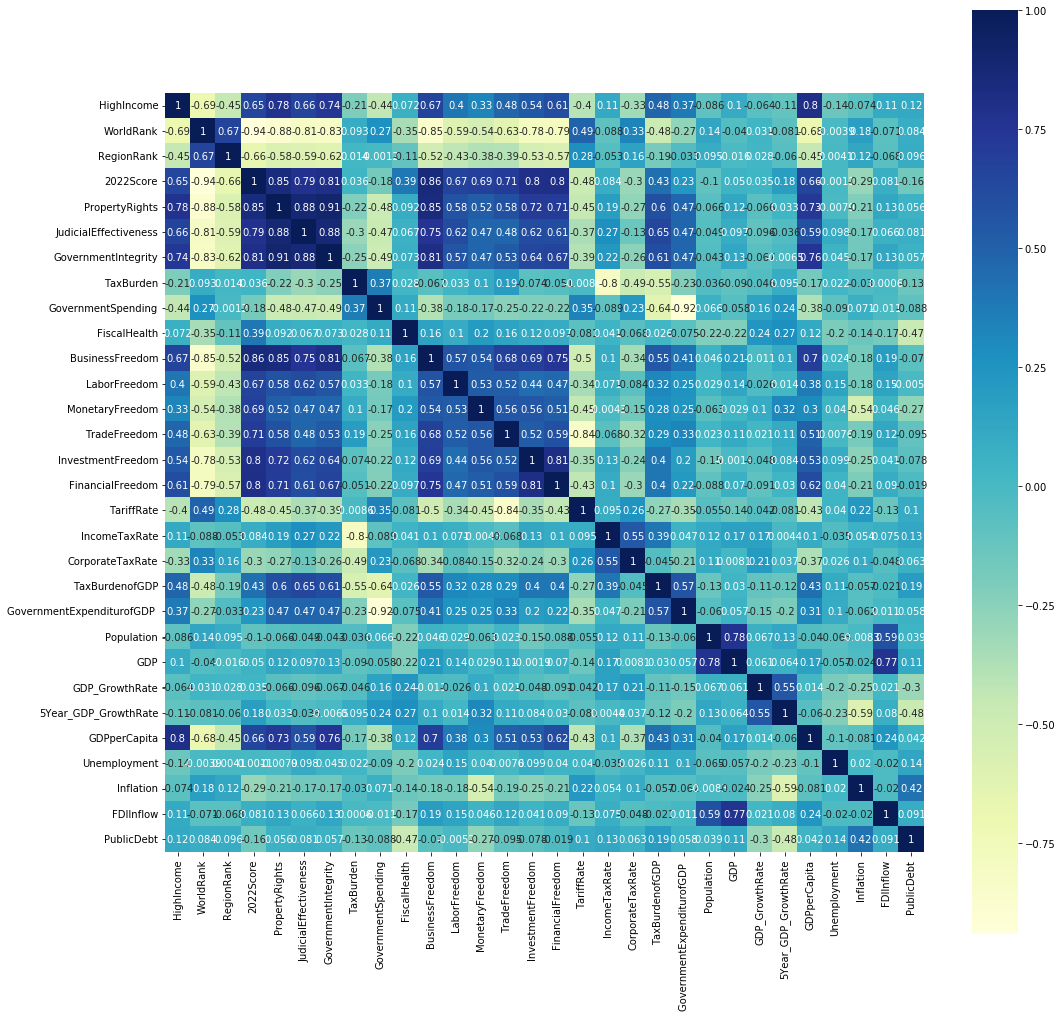

In [185]:
cor = df.corr('pearson')
plt.figure(figsize=(17, 17))
sns.heatmap(cor, square = True, cmap='YlGnBu', annot=True)
plt.show()

In [186]:
df.corrwith(df['PublicDebt']).sort_values(ascending=False)

PublicDebt                    1.000000
Inflation                     0.418033
TaxBurdenofGDP                0.188727
Unemployment                  0.140257
IncomeTaxRate                 0.132336
HighIncome                    0.119447
GDP                           0.114531
TariffRate                    0.104093
RegionRank                    0.095664
FDIInflow                     0.091043
WorldRank                     0.084360
JudicialEffectiveness         0.081396
CorporateTaxRate              0.063485
GovernmentExpenditurofGDP     0.058303
GovernmentIntegrity           0.056713
PropertyRights                0.055954
GDPperCapita                  0.041539
Population                    0.039422
LaborFreedom                 -0.005193
FinancialFreedom             -0.019042
BusinessFreedom              -0.069859
InvestmentFreedom            -0.078269
GovernmentSpending           -0.087680
TradeFreedom                 -0.094733
TaxBurden                    -0.133392
2022Score                

### Chosen variables:

Inflation, 5Year_GDP_GrowthRate, FiscalHealth, GDP_GrowthRate, MonetaryFreedom as continuous variables.

Income, Development and Region as categorical variables

In [187]:
df_target = df[['PublicDebt','Inflation','5Year_GDP_GrowthRate','FiscalHealth', 'GDP_GrowthRate', 'MonetaryFreedom','Income','Development','Region']]
df_target.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 184 entries, 1 to 186
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   PublicDebt            184 non-null    float64
 1   Inflation             184 non-null    float64
 2   5Year_GDP_GrowthRate  184 non-null    float64
 3   FiscalHealth          184 non-null    float64
 4   GDP_GrowthRate        184 non-null    float64
 5   MonetaryFreedom       184 non-null    float64
 6   Income                184 non-null    object 
 7   Development           184 non-null    object 
 8   Region                184 non-null    object 
dtypes: float64(6), object(3)
memory usage: 14.4+ KB


All the variables now have non-null values. Switching object vars to categorical:

In [192]:
df_target.describe()

,PublicDebt,Inflation,5Year_GDP_GrowthRate,FiscalHealth,GDP_GrowthRate,MonetaryFreedom
count,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000
mean,69.100299,21.058821,1.426423,60.978261,-4.887891,74.510870
std,44.092664,178.341368,3.157194,32.005460,7.763220,13.275261
min,2.854000,-2.719000,-23.466400,0.000000,-59.719000,0.000000
25%,42.903750,0.592500,-0.096800,38.350000,-7.500000,71.775000
50%,60.661000,2.482000,1.460600,70.800000,-4.059000,77.900000
75%,83.469000,4.919500,2.921250,87.425000,-1.211500,81.500000
max,304.125000,2355.147000,12.143800,99.700000,43.384000,87.100000


##### Hypothesis:

H1: The distribution of the variable 'PublicDebt' is different from the normal distribution

H0: The distribution of the variable 'PublicDebt' is not different from the normal distribution

p-value = 0.05

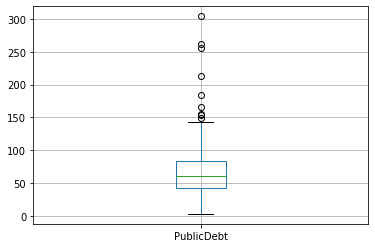

In [193]:
df_target.boxplot(column='PublicDebt')

C:\Users\Admin\Miniconda3\envs\IntroML\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Admin\Miniconda3\envs\IntroML\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
C:\Users\Admin\Miniconda3\envs\IntroML\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\Admin\Miniconda3\envs\IntroML\l

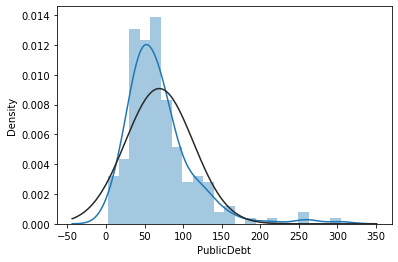

In [194]:
sns.distplot(df['PublicDebt'], fit=stats.norm)

In [195]:
stats.kstest(df['PublicDebt'], 'norm', args=(df['PublicDebt'].mean(), df['PublicDebt'].std()))

KstestResult(statistic=0.1375703591021762, pvalue=0.001687060888839159)

In [196]:
print('Skewness: {:.4f}'.format(df['PublicDebt'].skew()))
print('Kurtosis: {:.4f}'.format(df['PublicDebt'].kurt()))
print('Quartile Deviation: {:.4f}'.format((df['PublicDebt'].quantile(0.75) - df['PublicDebt'].quantile(0.25))/2))
print('Decile Ratio: {:.4f}'.format(df['PublicDebt'].quantile(0.9)/df['PublicDebt'].quantile(0.1)))

Skewness: 2.1515
Kurtosis: 7.2512
Quartile Deviation: 20.2826
Decile Ratio: 4.2152


##### Conclusion:

The dependent variable 'PublicDebt' deviates from the normal distribution (H1 is accepted at p-value = 0.05). It has a leptokurtic distribution with positive skewness.

There are also some outliers which have Public Debt > 200, which leads to a high decile ratio. In contrast, the quartile deviation is pretty low, so the values between 25 and 75 percentiles are not significantly dispersed

##### Hypothesis:

H1: The distribution of the variable 'Inflation' is different from the normal distribution

H0: The distribution of the variable 'Inflation' is not different from the normal distribution

p-value = 0.05

C:\Users\Admin\Miniconda3\envs\IntroML\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Admin\Miniconda3\envs\IntroML\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
C:\Users\Admin\Miniconda3\envs\IntroML\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\Admin\Miniconda3\envs\IntroML\l

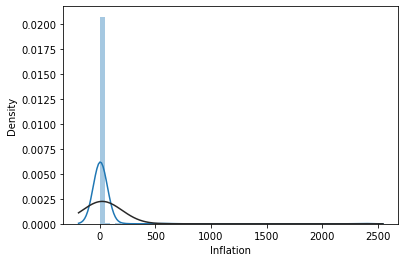

In [197]:
sns.distplot(df['Inflation'], fit=stats.norm)

In [198]:
stats.kstest(df['Inflation'], 'norm', args=(df['Inflation'].mean(), df['Inflation'].std()))

KstestResult(statistic=0.4523025124319727, pvalue=6.827573193325434e-35)

##### Conclusion:

The predictor variable 'Inflation' deviates from the normal distribution (H1 is accepted at p-value = 0.05).

##### Hypothesis:

H1: The distribution of the variable '5Year_GDP_GrowthRate' is different from the normal distribution

H0: The distribution of the variable '5Year_GDP_GrowthRate' is not different from the normal distribution

p-value = 0.05

C:\Users\Admin\Miniconda3\envs\IntroML\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Admin\Miniconda3\envs\IntroML\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
C:\Users\Admin\Miniconda3\envs\IntroML\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\Admin\Miniconda3\envs\IntroML\l

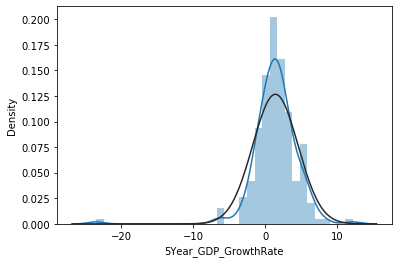

In [199]:
sns.distplot(df['5Year_GDP_GrowthRate'], fit=stats.norm)

In [200]:
stats.kstest(df['5Year_GDP_GrowthRate'], 'norm', args=(df['5Year_GDP_GrowthRate'].mean(), df['5Year_GDP_GrowthRate'].std()))

KstestResult(statistic=0.09857535495622266, pvalue=0.05223236943111642)

##### Conclusion:

The predictor variable '5Year_GDP_GrowthRate' does not deviate from the normal distribution (H1 is rejected at p-value = 0.05).

##### Hypothesis:

H1: The distribution of the variable 'FiscalHealth' is different from the normal distribution

H0: The distribution of the variable 'FiscalHealth' is not different from the normal distribution

p-value = 0.05

C:\Users\Admin\Miniconda3\envs\IntroML\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Admin\Miniconda3\envs\IntroML\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
C:\Users\Admin\Miniconda3\envs\IntroML\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\Admin\Miniconda3\envs\IntroML\l

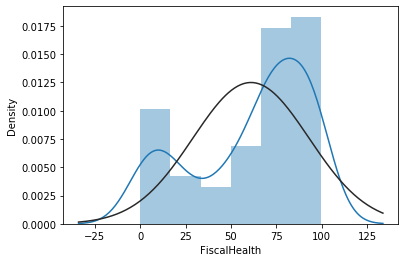

In [201]:
sns.distplot(df['FiscalHealth'], fit=stats.norm)

In [202]:
stats.kstest(df['FiscalHealth'], 'norm', args=(df['FiscalHealth'].mean(), df['FiscalHealth'].std()))

KstestResult(statistic=0.16456003949572068, pvalue=8.01588775272511e-05)

##### Conclusion:

The predictor variable 'FiscalHealth' deviates from the normal distribution (H1 is accepted at p-value = 0.05). According to the graph, FiscalHealth has bimodal distribution

##### Hypothesis:

H1: The distribution of the variable 'GDP_GrowthRate' is different from the normal distribution

H0: The distribution of the variable 'GDP_GrowthRate' is not different from the normal distribution

p-value = 0.05

C:\Users\Admin\Miniconda3\envs\IntroML\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Admin\Miniconda3\envs\IntroML\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
C:\Users\Admin\Miniconda3\envs\IntroML\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\Admin\Miniconda3\envs\IntroML\l

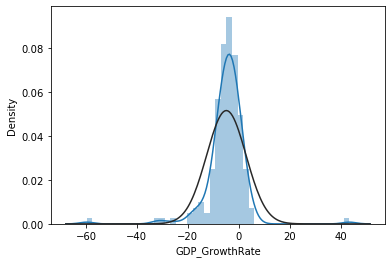

In [203]:
sns.distplot(df['GDP_GrowthRate'], fit=stats.norm)

In [204]:
stats.kstest(df['GDP_GrowthRate'], 'norm', args=(df['GDP_GrowthRate'].mean(), df['GDP_GrowthRate'].std()))

KstestResult(statistic=0.16943422418748494, pvalue=4.358625885462058e-05)

##### Conclusion:

The predictor variable 'GDP_GrowthRate' deviates from the normal distribution (H1 is accepted at p-value = 0.05).

##### Hypothesis:

H1: The distribution of the variable 'MonetaryFreedom' is different from the normal distribution

H0: The distribution of the variable 'MonetaryFreedom' is not different from the normal distribution

p-value = 0.05

C:\Users\Admin\Miniconda3\envs\IntroML\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Admin\Miniconda3\envs\IntroML\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
C:\Users\Admin\Miniconda3\envs\IntroML\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\Admin\Miniconda3\envs\IntroML\l

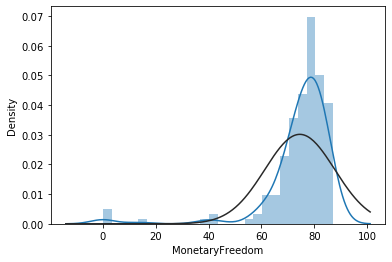

In [205]:
sns.distplot(df['MonetaryFreedom'], fit=stats.norm)

In [206]:
stats.kstest(df['MonetaryFreedom'], 'norm', args=(df['MonetaryFreedom'].mean(), df['MonetaryFreedom'].std()))

KstestResult(statistic=0.20396191610130593, pvalue=3.4513985648688644e-07)

##### Conclusion:

The predictor variable 'MonetaryFreedom' deviates from the normal distribution (H1 is accepted at p-value = 0.05).

#### Correlation

Since most variables are not normally distributed, Spearman correlation can be used:

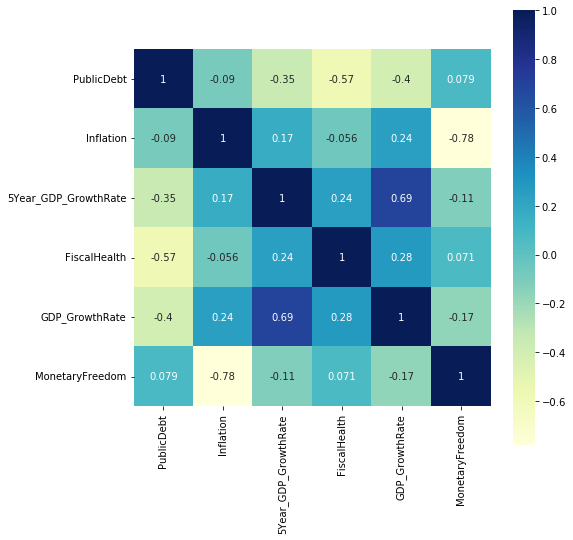

In [207]:
cor = df_target.corr('spearman')
plt.figure(figsize=(8, 8))
sns.heatmap(cor, square = True, cmap='YlGnBu', annot=True)
plt.show()

From the correlation analysis, we can see that there is a positive moderate-to-strong correlation between GDP_GrowthRate and 5Year_GDP_GrowthRate (which seems logical as the variables represent nearly the same aspect). There is also a positive medium correlation between FiscalHealth and PublicDebt and a strong negative correlation between Inflation and MonetaryFreedom. Potentially, these highly or moderately correlated variables can be splitted into factors

### Categorical variable description

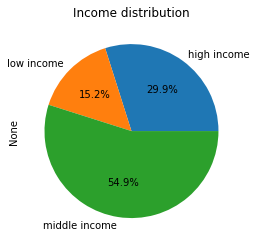

In [208]:
cont_rating_df = df.groupby('Income').size().plot(kind='pie', title = 'Income distribution',autopct='%1.1f%%')

It is seen that most countries have middle income (>54%), about a third part has a high income (30%) and only 15% have low income

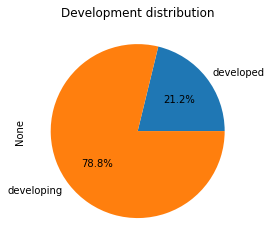

In [209]:
cont_rating_df = df.groupby('Development').size().plot(kind='pie', title = 'Development distribution',autopct='%1.1f%%')

Most counries (>78%) are marked as developing and only 21% of countries are already developed

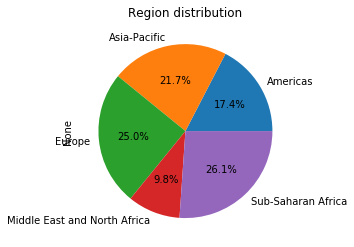

In [210]:
cont_rating_df = df.groupby('Region').size().plot(kind='pie', title = 'Region distribution',autopct='%1.1f%%')

It is seen that most countries are alloted to Sub-Saharan Africa and Europe, while the least countries are in the Middle East and North Africa

### Description of relationships between predictors and the dependent variable

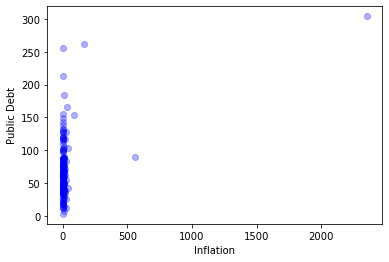

In [211]:
plt.scatter(df_target['Inflation'], df_target['PublicDebt'], c = 'blue', marker = 'o', alpha=0.3)
plt.xlabel('Inflation')
plt.ylabel('Public Debt')
plt.show()

Despite the one outlier, it is not really possible to say that there is a linear relationship between Inflation and Public Debt. According to the correlation matrix, the correlation between them is nearly -0.09, which is even less than very weak.

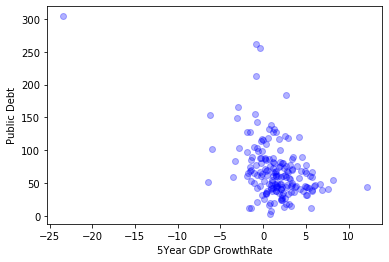

In [212]:
plt.scatter(df_target['5Year_GDP_GrowthRate'], df_target['PublicDebt'], c = 'blue', marker = 'o', alpha=0.3)
plt.xlabel('5Year GDP GrowthRate')
plt.ylabel('Public Debt')
plt.show()

There is no explicit linear relationship between 5 Year GDP Growth and Public Debt, but according to the correlation matrixt there is a weak negative correlation between variables.

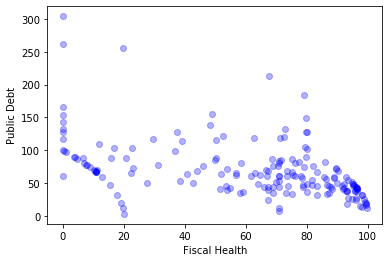

In [213]:
plt.scatter(df_target['FiscalHealth'], df_target['PublicDebt'], c = 'blue', marker = 'o', alpha=0.3)
plt.xlabel('Fiscal Health')
plt.ylabel('Public Debt')
plt.show()

There is some sort of linear relationship between Public Debt and Fiscal Health, but according to the graph the relationship between them is more close to logistic one. According to the corr. matrix, these variables have a medium negative correlation

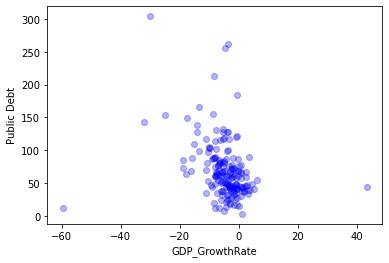

In [214]:
plt.scatter(df_target['GDP_GrowthRate'], df_target['PublicDebt'], c = 'blue', marker = 'o', alpha=0.3)
plt.xlabel('GDP_GrowthRate')
plt.ylabel('Public Debt')
plt.show()

There is a sort of linear relationship between the variables. According to the corr matrix, the have a negative weak-to-moderate correlation.

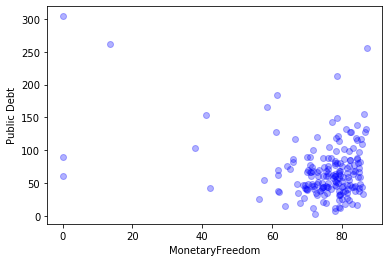

In [215]:
plt.scatter(df_target['MonetaryFreedom'], df_target['PublicDebt'], c = 'blue', marker = 'o', alpha=0.3)
plt.xlabel('MonetaryFreedom')
plt.ylabel('Public Debt')
plt.show()

There is no linear relationship between Public Debt and Monetary Freedom. Seems that this variable had a correlation based on Pearson correlation (that is why it was taken), but based on the Spearman approach there is almost no correlation between these variables

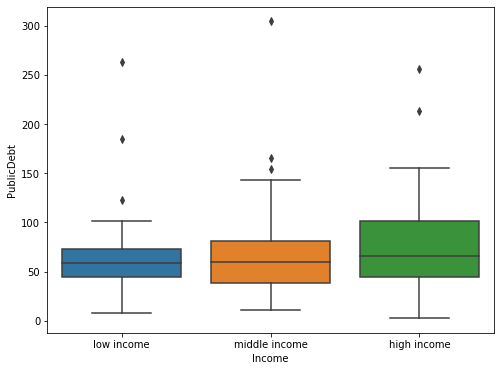

In [216]:
plt.figure(figsize=(8, 6))
fig = sns.boxplot(x=df['Income'], y='PublicDebt', 
                  data=pd.concat([df['PublicDebt'], df['Income']], axis=1))
plt.show()

There is a relationship between income level and public debt: the higher the income, the higher the debt

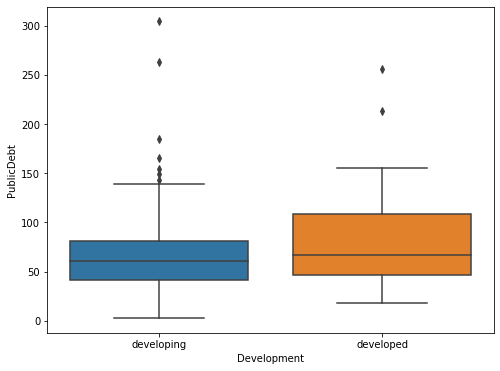

In [217]:
plt.figure(figsize=(8, 6))
fig = sns.boxplot(x=df['Development'], y='PublicDebt', 
                  data=pd.concat([df['PublicDebt'], df['Development']], axis=1))
plt.show()

There is a relationship between Development level and Public debt: in developing countries public debt is significantly lower than in developed countries

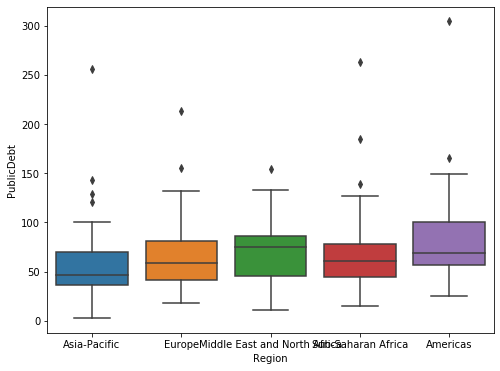

In [218]:
plt.figure(figsize=(8, 6))
fig = sns.boxplot(x=df['Region'], y='PublicDebt', 
                  data=pd.concat([df['PublicDebt'], df['Region']], axis=1))
plt.show()

There is a relationship between regions and public debt: the highest average public debt is in Americas, the next ones are Middle East and North Africa with Europe. The lower debts are in Subsaharan Africa and Asia-Pacific

### Factor Analysis

Hypothesis:

- H0: varaibles from the set{Inflation, 5Year_GDP_GrowthRate, FiscalHealth, GDP_GrowthRate, MonetaryFreedom} are unrelated
- H1: variables from the aforementioned set are somehow related.

p-value: 0.05

The hypothesis is checked using Bartlett's test of sphericity.

In [219]:
df_factor = df_target[['Inflation','5Year_GDP_GrowthRate','FiscalHealth', 'GDP_GrowthRate', 'MonetaryFreedom']]

In [220]:
calculate_bartlett_sphericity(df_factor)

(236.88872265708108, 3.0825028970958396e-45)

#### Conclusion:

H0 is rejected since p-value is less than 0.05, so there are statistically significant relations between variables

Let us also perfrom the Kaiser–Meyer–Olkin (KMO) test to determine how suited data is for factor analysis:

In [221]:
_, kmo_model = calculate_kmo(df_factor)
kmo_model

0.6213929641052759

Data sample is mediocre for the factor analysis

In [222]:
fa = FactorAnalyzer(n_factors=5, rotation='varimax', method='principal') 
#factor model for 5 factors, which corresponds to the total number of variables
fa.fit(df_factor)

FactorAnalyzer(bounds=(0.005, 1), impute='median', is_corr_matrix=False,
               method='principal', n_factors=5, rotation='varimax',
               rotation_kwargs={}, svd_method='randomized', use_smc=True)

In [223]:
ev, v = fa.get_eigenvalues()
ev[ev > 1]

array([2.34759864, 1.04494193])

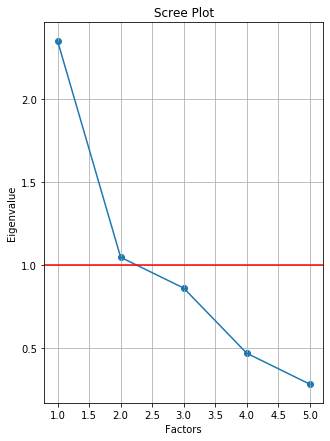

In [224]:
plt.figure(figsize=(5, 7))
plt.scatter(range(1, df_factor.shape[1]+1), ev)
plt.plot(range(1, df_factor.shape[1]+1), ev)
plt.axhline(y=1, color='r', linestyle='-')
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

#### Conclusion:

Based on the analysis of the eigenvalues, it is better to make 2 factors

### Result factor model

In [225]:
fa = FactorAnalyzer(n_factors=2, rotation='varimax', method='principal') 
#factor model with 2 factors
fa.fit(df_factor)

FactorAnalyzer(bounds=(0.005, 1), impute='median', is_corr_matrix=False,
               method='principal', n_factors=2, rotation='varimax',
               rotation_kwargs={}, svd_method='randomized', use_smc=True)

### Communalities

In [226]:
communalities = pd.DataFrame(data=fa.get_communalities(), 
                       index=df_factor.columns, 
                       columns=['Communalities'])
communalities.sort_values('Communalities')

,Communalities
FiscalHealth,0.339422
5Year_GDP_GrowthRate,0.749210
GDP_GrowthRate,0.757378
MonetaryFreedom,0.760868
Inflation,0.785663


It is seen from communalities, that all the variables fit well into the model, however the Fiscal Health fits the worst (but still above the border of 0.3)

### Cumulative variance of the initial variables explained by the model

In [227]:
factor_variance = pd.DataFrame(data=fa.get_factor_variance()[1:3],
                              index=['Proportional variance', 'Cumulative variance'],
                              columns=['Factor 1', 'Factor 2'])
factor_variance

,Factor 1,Factor 2
Proportional variance,0.342862,0.335646
Cumulative variance,0.342862,0.678508


The model with 4 factors describes 68% of variance of the initial variables, which should be sufficient enough for the further analysis of the data.

### Factor description based on loading matrix

In [228]:
factors = pd.DataFrame(data=fa.loadings_, 
                       index=df_factor.columns, 
                       columns=['Factor_1', 'Factor_2'])
factors

,Factor_1,Factor_2
Inflation,-0.845558,-0.265885
5Year_GDP_GrowthRate,0.480376,0.720034
FiscalHealth,0.085694,0.576263
GDP_GrowthRate,0.022958,0.869972
MonetaryFreedom,0.872186,0.012630


- Factor_1 has a high positive correlation with monetary freedom, a high negative correlation with Inflation and medium positive correlation with 5 Year GDP Growth Rate, but the second factor correlates much better with this variable, so it is decided to omit it in the name of the factor. The name for the factor: MonetaryFreedomAtTheCostOfInflation
- Factor_2 has a high positive correlation with 5 Year GDP Growth Rate and GDP Growth Rate, medium positive correlation with Fiscal Health. The name for the factor: GDP_Growth&FiscalHealth

In [229]:
transformed = pd.DataFrame(data=fa.transform(df_factor),
                           index=df_factor.index,
                           columns=['MonetaryFreedomAtTheCostOfInflation','GDP_Growth&FiscalHealth'])
transformed

,MonetaryFreedomAtTheCostOfInflation,GDP_Growth&FiscalHealth
CountryID,,
1,0.150712,-0.005128
2,0.348613,0.158977
3,0.342675,-0.608355
4,-0.825208,0.129291
5,-1.612678,-0.800811
...,...,...
182,-0.189931,-0.431609
183,-4.958246,1.027036
184,0.093514,0.351405


In [230]:
df_target['MonetaryFreedomAtTheCostOfInflation'] = transformed['MonetaryFreedomAtTheCostOfInflation'].values
df_target['GDP_Growth&FiscalHealth'] = transformed['GDP_Growth&FiscalHealth'].values
df_target

<ipython-input-230-c3a565c63b91>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_target['MonetaryFreedomAtTheCostOfInflation'] = transformed['MonetaryFreedomAtTheCostOfInflation'].values
<ipython-input-230-c3a565c63b91>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_target['GDP_Growth&FiscalHealth'] = transformed['GDP_Growth&FiscalHealth'].values


,PublicDebt,Inflation,5Year_GDP_GrowthRate,FiscalHealth,GDP_GrowthRate,MonetaryFreedom,Income,Development,Region,MonetaryFreedomAtTheCostOfInflation,GDP_Growth&FiscalHealth
CountryID,,,,,,,,,,,
1,7.785,5.607,0.9824,70.8,-5.000,77.9,low income,developing,Asia-Pacific,0.150712,-0.005128
2,75.960,1.603,1.9856,70.6,-3.500,82.0,middle income,developing,Europe,0.348613,0.158977
3,53.067,2.415,0.1016,38.6,-5.992,80.1,middle income,developing,Middle East and North Africa,0.342675,-0.608355
4,127.115,22.277,-1.8610,80.0,-3.975,61.2,middle income,developing,Sub-Saharan Africa,-0.825208,0.129291
5,102.998,42.015,-2.7740,16.8,-9.956,37.9,middle income,developing,Americas,-1.612678,-0.800811
...,...,...,...,...,...,...,...,...,...,...,...
182,117.761,16.350,1.8520,0.0,-3.497,66.4,middle income,developing,Sub-Saharan Africa,-0.189931,-0.431609
183,88.873,557.210,-1.2930,79.8,-8.002,0.0,middle income,developing,Sub-Saharan Africa,-4.958246,1.027036
184,60.661,2.482,1.6958,70.8,-1.500,77.9,low income,developing,Sub-Saharan Africa,0.093514,0.351405


In [231]:
df_target = df_target.drop(['Inflation','5Year_GDP_GrowthRate','FiscalHealth', 'GDP_GrowthRate', 'MonetaryFreedom'], 1)

<ipython-input-231-838fa6ee869c>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_target = df_target.drop(['Inflation','5Year_GDP_GrowthRate','FiscalHealth', 'GDP_GrowthRate', 'MonetaryFreedom'], 1)


## Linear Regression Analysis

(Phase of checking relationships between predictors and dependent var is skipped since it is presented below)

#### Hypothesis:

H0: The linear regression model constructed for a dependent variable 'PublicDebt' and the following predictors:
- MonetaryFreedomAtTheCostOfInflation
- GDP_Growth&FiscalHealth
- Income (cat.)
- Development (cat.)
- Region (cat.)

explains the variation of 'PublicDebt'.

H1: The aforementioned model does not explain the variation of 'PublicDebt'.

p-value = 0.05.

The hypothesis can be checked based on R^2 of the model as well as based on the results of F-test

In [232]:
df_with_dummies = pd.get_dummies(df_target, columns=['Income','Development','Region'])

In [233]:
df_with_dummies

,PublicDebt,MonetaryFreedomAtTheCostOfInflation,GDP_Growth&FiscalHealth,Income_high income,Income_low income,Income_middle income,Development_developed,Development_developing,Region_Americas,Region_Asia-Pacific,Region_Europe,Region_Middle East and North Africa,Region_Sub-Saharan Africa
CountryID,,,,,,,,,,,,,
1,7.785,0.150712,-0.005128,0,1,0,0,1,0,1,0,0,0
2,75.960,0.348613,0.158977,0,0,1,0,1,0,0,1,0,0
3,53.067,0.342675,-0.608355,0,0,1,0,1,0,0,0,1,0
4,127.115,-0.825208,0.129291,0,0,1,0,1,0,0,0,0,1
5,102.998,-1.612678,-0.800811,0,0,1,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,117.761,-0.189931,-0.431609,0,0,1,0,1,0,0,0,0,1
183,88.873,-4.958246,1.027036,0,0,1,0,1,0,0,0,0,1
184,60.661,0.093514,0.351405,0,1,0,0,1,0,0,0,0,1


Taking only n-1 dummy variables into the model

In [234]:
import statsmodels.api as sm

x_mult = df_with_dummies[['MonetaryFreedomAtTheCostOfInflation','GDP_Growth&FiscalHealth','Income_high income', 'Income_middle income','Development_developed','Region_Americas','Region_Asia-Pacific','Region_Europe','Region_Sub-Saharan Africa']]

In [235]:
y = df_with_dummies['PublicDebt']
x_mult_constant = sm.add_constant(x_mult)

In [236]:
model = sm.OLS(y, x_mult_constant).fit()

In [237]:
print('R^2 = {:f}'.format(model.rsquared))
print('F-test significance = {:f}'.format(model.f_pvalue))

R^2 = 0.384589
F-test significance = 0.000000


#### Conclusion:

The model is statistically significant and explains 38% of variance of variable 'PublicDebt'. H1 is rejected at p-value = 0.05

### Model Characteristics:

- H0_1: The variable MonetaryFreedomAtTheCostOfInflation is statistically significant for the linear regression model constructed for a dependent variable 'PublicDebt'
- H0_2: The variable GDP_Growth&FiscalHealth is statistically significant for the linear regression model constructed for a dependent variable 'PublicDebt'
- H0_3: The variable Income is statistically significant for the linear regression model constructed for a dependent variable 'PublicDebt'
- H0_4: The variable Development is statistically significant for the linear regression model constructed for a dependent variable 'PublicDebt'
- H0_5: The variable Region is statistically significant for the linear regression model constructed for a dependent variable 'PublicDebt'

- H1_1: The variable MonetaryFreedomAtTheCostOfInflation is not statistically significant for the linear regression model constructed for a dependent variable 'PublicDebt'
- H1_2: The variable GDP_Growth&FiscalHealth is not statistically significant for the linear regression model constructed for a dependent variable 'PublicDebt'
- H1_3: The variable Income is not statistically significant for the linear regression model constructed for a dependent variable 'PublicDebt'
- H1_4: The variable Development is not statistically significant for the linear regression model constructed for a dependent variable 'PublicDebt'
- H1_5: The variable Region is not statistically significant for the linear regression model constructed for a dependent variable 'PublicDebt'

p-value = 0.05

The hypothesis can be checked by estimating p-values of each variable in the constructed model

In [238]:
print(f'Statistically significant model parameters: {model.pvalues[model.pvalues < 0.05].index.values}')

Statistically significant model parameters: ['const' 'MonetaryFreedomAtTheCostOfInflation' 'GDP_Growth&FiscalHealth'
 'Development_developed']


In [239]:
print(f'Statistically nonsignificant model parameters: {model.pvalues[model.pvalues > 0.05].index.values}')

Statistically nonsignificant model parameters: ['Income_high income' 'Income_middle income' 'Region_Americas'
 'Region_Asia-Pacific' 'Region_Europe' 'Region_Sub-Saharan Africa']


#### Conclusion:

Variables MonetaryFreedomAtTheCostOfInflation, GDP_Growth&FiscalHealth and Development are statistically significant, others are not.
Therefore, H1_1, H1_2, H1_4 are rejected at p-value = 0.05, others are accepted

### Regression equation

In [240]:
l = []
for (param, index) in zip(model.params[1:], model.params.index[1:]):
    l.append('{:.2f}*{}'.format(param, index))
    
print('Y = {:2f} + {}'.format(model.params[0], ' + '.join(l)))

Y = 61.923176 + -15.41*MonetaryFreedomAtTheCostOfInflation + -20.85*GDP_Growth&FiscalHealth + -4.50*Income_high income + -6.70*Income_middle income + 30.58*Development_developed + 10.05*Region_Americas + 5.88*Region_Asia-Pacific + -5.20*Region_Europe + 15.30*Region_Sub-Saharan Africa


### Model description

In [241]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             PublicDebt   R-squared:                       0.385
Model:                            OLS   Adj. R-squared:                  0.353
Method:                 Least Squares   F-statistic:                     12.08
Date:                Sat, 16 Apr 2022   Prob (F-statistic):           9.87e-15
Time:                        15:53:56   Log-Likelihood:                -912.60
No. Observations:                 184   AIC:                             1845.
Df Residuals:                     174   BIC:                             1877.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co

Considering only significant variables:

- Let's consider the coefficient on the variable MonetaryFreedomAtTheCostOfInflation. The regression coefficient for the variable is negative and equals -15.4. It can be concluded that an increase in this indicator by one, on average, leads to a decrease of the public debt by 15% of GDP. So, having high monetary freedom and low inflation leads to a decrease of the public debt.
- Let's consider the coefficient on the variable GDP_Growth&FiscalHealth. The regression coefficient for the variable is negative and equals -20.5. It can be concluded that an increase in this indicator by one, on average, leads to a decrease of the public debt by 20.5% of GDP. So, having high GDP growth and good fiscal health leads to a decrease in the public debt.
- Let's consider the coefficient on the dummy variable of Development. The reference group is Developing countries. If the country is already developed, the public debt increases by 30% of GDP (in comparison to the reference group, if it is possible to say).

All the other variables are insignificant

### Model with standardized coefficients (beta coefficients)

In [242]:
from scipy.stats.mstats import zscore
print(sm.OLS(zscore(y), zscore(x_mult)).fit().summary())

                                 OLS Regression Results                                
Dep. Variable:             PublicDebt   R-squared (uncentered):                   0.385
Model:                            OLS   Adj. R-squared (uncentered):              0.353
Method:                 Least Squares   F-statistic:                              12.15
Date:                Sat, 16 Apr 2022   Prob (F-statistic):                    7.89e-15
Time:                        15:53:56   Log-Likelihood:                         -216.42
No. Observations:                 184   AIC:                                      450.8
Df Residuals:                     175   BIC:                                      479.8
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
                                          coef    std err          t      P>|t|      [0.025      0.975]
----------------

It is seen that predictors with the greatest influence are the following:

- MonetaryFreedomAtTheCostOfInflation
- GDP_Growth&FiscalHealth
- Development

All of them have quite low std error, so these variables are quite precise

## Model Diagnostics

#### Residuals

To evaluate how he model fits the sample data, the residuals can be calculated. Small residuals show that fits the sample data well

##### Hypothesis:

H1: The distribution of residuals is different from the normal distribution

H0: The distribution of residuals is not different from the normal distribution

p-value = 0.05

In [243]:
p = stats.kstest(model.resid, 'norm', args=(model.resid.mean(), model.resid.std())).pvalue
print('P-value: {:.3f}'.format(p))

P-value: 0.050


C:\Users\Admin\Miniconda3\envs\IntroML\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Admin\Miniconda3\envs\IntroML\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
C:\Users\Admin\Miniconda3\envs\IntroML\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\Admin\Miniconda3\envs\IntroML\l

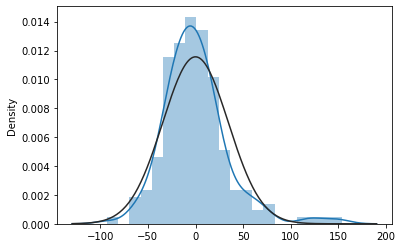

In [244]:
sns.distplot(model.resid, fit=stats.norm) 

##### Conclusion:

H1 is rejected at p-value = 0.05 (although it is at the border): the distribution of residuals is not different from the normal distribution. The model fits well the data

#### Multicollinearity

Multicollinearity can be checked to find any strong correlations between predictors

In [245]:
vifs = np.array([vif(model.model.exog, i) for i in range(model.model.exog.shape[1])])

vif_df = pd.DataFrame()
vif_df['VIF'] = vifs[1:]
vif_df['Features'] = model.params.index[1:]
vif_df.sort_values(by=['VIF'])

,VIF,Features
0,1.074177,MonetaryFreedomAtTheCostOfInflation
1,1.199362,GDP_Growth&FiscalHealth
5,2.388236,Region_Americas
3,2.734286,Income_middle income
6,2.819504,Region_Asia-Pacific
8,3.254136,Region_Sub-Saharan Africa
4,3.675494,Development_developed
7,3.947927,Region_Europe
2,4.504401,Income_high income


All VIF < 10, so there is no multicollinearity problem in the model (probably, the factor analysis has removed the possibility of it among the float variables)

### Heteroscedasticity

To check the well-fitness of the model, the heteroscedasticity can be evaluated. If the model is well-fitted, there should be no pattern to the residuals plotted against the fitted values.

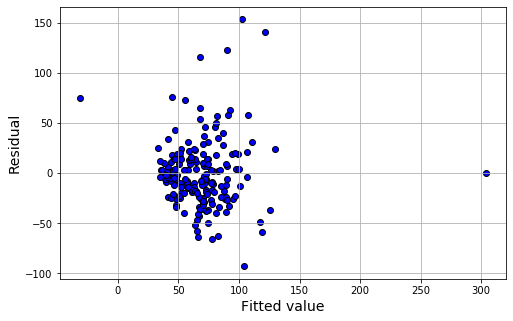

In [246]:
plt.figure(figsize=(8,5))
plt.scatter(x=model.fittedvalues, y=model.resid, color='blue', edgecolor='k')
plt.grid(True)
plt.xlabel('Fitted value', fontsize=14)
plt.ylabel('Residual', fontsize=14)
plt.show()

##### Conclusion:

Generally, the model can be characterized to be both homoscedastic. According to Durbin-Watson, there is homoscedasticity in the model (value equals 1.85, while values in range [1,2] represent homoscedasticity).

### Outliers and influential cases

Influential cases can be detected using DFFITS techniqe. Outliers can be detected by checking the standardized residuals of cases in the sample

In [247]:
influence = model.get_influence()
inf_sum = influence.summary_frame()
inf_sum

,dfb_const,dfb_MonetaryFreedomAtTheCostOfInflation,dfb_GDP_Growth&FiscalHealth,dfb_Income_high income,dfb_Income_middle income,dfb_Development_developed,dfb_Region_Americas,dfb_Region_Asia-Pacific,dfb_Region_Europe,dfb_Region_Sub-Saharan Africa,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
CountryID,,,,,,,,,,,,,,,,
1,-0.256902,-0.063520,0.105058,0.299897,0.404825,0.016991,-0.034801,-0.187238,-0.063830,0.085976,0.024686,-1.697741,0.078889,-0.496847,-1.707053,-0.499572
2,0.008011,0.028492,-0.004517,-0.009166,0.002909,-0.120575,0.006104,0.002033,0.148236,-0.007652,0.005579,1.002782,0.052568,0.236207,1.002798,0.236211
3,-0.049781,-0.006747,-0.000352,0.013647,-0.010512,-0.015510,0.057274,0.058926,0.052368,0.056656,0.000546,-0.278825,0.065645,-0.073905,-0.278085,-0.073709
4,-0.095727,-0.078127,0.003622,0.093245,0.158055,0.021792,-0.021728,-0.013702,-0.019969,0.124321,0.006837,1.337587,0.036806,0.261473,1.340649,0.262072
5,0.000260,0.011214,0.002326,0.001514,-0.002123,-0.001662,-0.010024,0.000638,-0.000304,0.000837,0.000056,-0.110070,0.044361,-0.023715,-0.109758,-0.023648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,-0.071985,-0.007664,-0.045360,0.055637,0.108396,0.016677,-0.010517,0.002402,-0.004951,0.104962,0.003785,1.013511,0.035540,0.194556,1.013591,0.194572
183,0.104723,0.472477,-0.105464,-0.159237,-0.193175,-0.021380,0.057178,0.044714,0.043046,-0.083016,0.028458,-1.140415,0.179531,-0.533459,-1.141407,-0.533923
184,-0.019360,-0.007669,0.003759,0.021492,0.030287,0.000418,-0.002852,-0.002187,-0.003138,-0.008871,0.000205,-0.224267,0.039078,-0.045226,-0.223654,-0.045103


#### Potential influential cases

Such cases can be found using difference in fit(s) diagnostic (DFFITS). DFFITS value shows how influential a particual case on the whole model

In [248]:
inf_sum['dffits'][(inf_sum['dffits']>1) | (inf_sum['dffits']<-1)].sort_values()

CountryID
96    -1.205015
154    1.304877
68     1.333500
82     1.469546
Name: dffits, dtype: float64

#### Potential outliers

Based on standardized residuals, it is possible to identify outliers (whose value has to be less than -3 or greater than 3)

In [249]:
inf_sum['standard_resid'][(inf_sum['standard_resid']>3) | (inf_sum['standard_resid']<-3)].sort_values()

CountryID
53     3.351136
64     3.515459
154    4.147332
82     4.529041
Name: standard_resid, dtype: float64

#### Conclusions:

The quantity of influetial cases and outliers is sufficiently low: both influential cases and outliers have only 4 rows, while 2 of them intesect (ids: 154, 82), which means that, indeed, the outliers had an influence on the model. Potentially, in the future outliers can be removed to improve the model quality

### Final Conclusions

The constructed linear model appeared to be statistically significant but explains only 38% variance of the public deby. Since this indicator is quite low, the model still has to be readjusted and refined. For instance, the statistically insignificant variables can be removed from the model. Another way is to remove all the outliers from the sample. As it is presented above, these outliers highly influence the model since 2 of them are represented in the set of the most influential cases.

All in all, it is possible to say that, in general, an increase of monetary freedom, GDP growth and increase of quality of fiscal health 'leads' to an increase of the public debt. Decrease of inflation also increases the public debt. According to the model, if the country is developed it public debt increases by 30% of GDP at average in comparison to developing countries.

# Task 2

Based on the correlation matrix presented above, the following continuous variables have been chosen (have one of lowest correlations with each other as well as with the Public Debt): PropertyRights, TaxBurden, GDP_GrowthRate, FiscalHealth, Population

In [250]:
df_cluster = df[['PublicDebt','PropertyRights','TaxBurden','GDP_GrowthRate', 'FiscalHealth', 'Population']]

### Let us evaluate distribution of each var to further get correlations between columns. Highly correlated variables should not be included into consideration for clustering
#### Hypotheses:

For each variable in {PropertyRights, TaxBurden, GDP_GrowthRate, FiscalHealth, Population}:

H1: The distribution of the variable is different from the normal distribution

H0: The distribution of the variable is not different from the normal distribution

p-value = 0.05

Kolmogorov test can be used here as the sizes of non-null values in columns is sufficiently high

C:\Users\Admin\Miniconda3\envs\IntroML\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Admin\Miniconda3\envs\IntroML\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
C:\Users\Admin\Miniconda3\envs\IntroML\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\Admin\Miniconda3\envs\IntroML\l

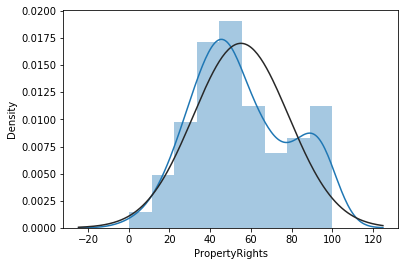

In [251]:
sns.distplot(df_cluster.PropertyRights.dropna(), fit=norm)

In [252]:
stats.kstest(df_cluster.PropertyRights.dropna(), 'norm', args=(df_cluster.PropertyRights.dropna().mean(), df_cluster.PropertyRights.dropna().std()))

KstestResult(statistic=0.10397129021988571, pvalue=0.03476224049144094)

#### Conclusion:
p-value < 0.05 => H1 is accepted at 5% for PropertyRights

C:\Users\Admin\Miniconda3\envs\IntroML\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Admin\Miniconda3\envs\IntroML\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
C:\Users\Admin\Miniconda3\envs\IntroML\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\Admin\Miniconda3\envs\IntroML\l

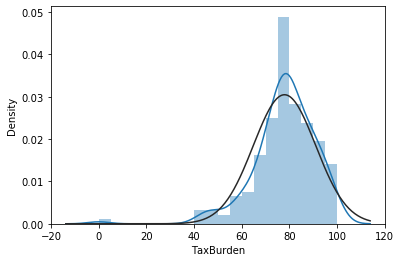

In [253]:
sns.distplot(df_cluster.TaxBurden.dropna(), fit=norm)

In [254]:
stats.kstest(df_cluster.TaxBurden.dropna(), 'norm', args=(df_cluster.TaxBurden.dropna().mean(), df_cluster.TaxBurden.dropna().std()))

KstestResult(statistic=0.08873554696131408, pvalue=0.10378247221130377)

#### Conclusion:
p-value > 0.05 => H1 is rejected at 5% for TaxBurden. TaxBurden is normally distributed

C:\Users\Admin\Miniconda3\envs\IntroML\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Admin\Miniconda3\envs\IntroML\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
C:\Users\Admin\Miniconda3\envs\IntroML\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\Admin\Miniconda3\envs\IntroML\l

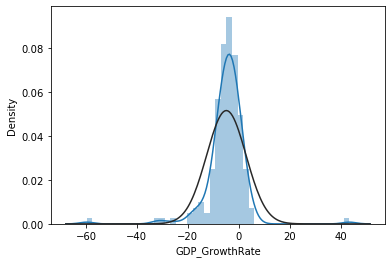

In [255]:
sns.distplot(df_cluster.GDP_GrowthRate.dropna(), fit=norm)

In [256]:
stats.kstest(df_cluster.GDP_GrowthRate.dropna(), 'norm', args=(df_cluster.GDP_GrowthRate.dropna().mean(), df_cluster.GDP_GrowthRate.dropna().std()))

KstestResult(statistic=0.16943422418748494, pvalue=4.358625885462058e-05)

#### Conclusion:
p-value < 0.05 => H1 is accepted at 5% for GDP_GrowthRate

C:\Users\Admin\Miniconda3\envs\IntroML\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Admin\Miniconda3\envs\IntroML\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
C:\Users\Admin\Miniconda3\envs\IntroML\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\Admin\Miniconda3\envs\IntroML\l

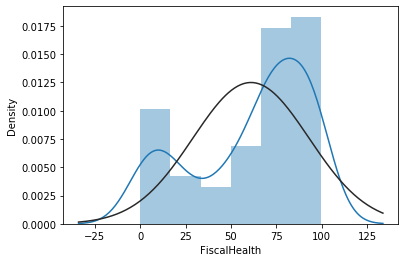

In [257]:
sns.distplot(df_cluster.FiscalHealth.dropna(), fit=norm)

In [258]:
stats.kstest(df_cluster.FiscalHealth.dropna(), 'norm', args=(df_cluster.FiscalHealth.dropna().mean(), df_cluster.FiscalHealth.dropna().std()))

KstestResult(statistic=0.16456003949572068, pvalue=8.01588775272511e-05)

#### Conclusion:
p-value < 0.05 => H1 is accepted at 5% for FiscalHealth. Fiscal health has bimodal distribution

C:\Users\Admin\Miniconda3\envs\IntroML\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Admin\Miniconda3\envs\IntroML\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
C:\Users\Admin\Miniconda3\envs\IntroML\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\Admin\Miniconda3\envs\IntroML\l

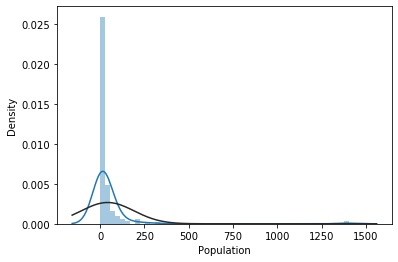

In [259]:
sns.distplot(df_cluster.Population.dropna(), fit=norm)

In [260]:
stats.kstest(df_cluster.Population.dropna(), 'norm', args=(df_cluster.Population.dropna().mean(), df_cluster.Population.dropna().std()))

KstestResult(statistic=0.38967994764078767, pvalue=1.1294446452642951e-25)

#### Conclusion:
p-value < 0.05 => H1 is accepted at 5% for Population

Since most of variables are not normally distributed, Pearson correlation should be used:

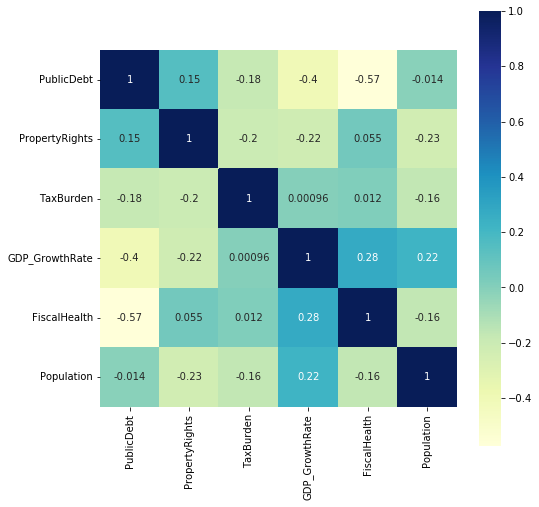

In [261]:
cor = df_cluster.corr('spearman')
plt.figure(figsize=(8, 8))
sns.heatmap(cor, square = True, cmap='YlGnBu', annot=True)
plt.show()

It is seen that there is no strong correlation between any variables, so all of them can be used for cluster analysis

### Choice of the algorithm: K-Means

Since the quantity of elements is quite high - 184, it is generally better to use K-Means. For instance, the dendrogramm for the hierarchical clustering would probably be not readable

### Getting cluster number

#### Using Calinski-Harabasz Index to get number of clusters

In [262]:
X = df_cluster[['PropertyRights', 'TaxBurden', 'GDP_GrowthRate', 'FiscalHealth', 'Population', 'PublicDebt']]
for k in range (2, 15):
    labels = KMeans(n_clusters=k).fit_predict(X)
    print('Number of clusters: {}, index {}'.format(k, calinski_harabasz_score(X, labels)))

Number of clusters: 2, index 609.3852672095511
Number of clusters: 3, index 447.99965758533847
Number of clusters: 4, index 442.42929004768655
Number of clusters: 5, index 401.7388503480171
Number of clusters: 6, index 383.46286889092346
Number of clusters: 7, index 376.3950577893346
Number of clusters: 8, index 371.6388538734728
Number of clusters: 9, index 353.0569367919204
Number of clusters: 10, index 341.1035806034029
Number of clusters: 11, index 327.81870122105084
Number of clusters: 12, index 316.42843178063254
Number of clusters: 13, index 304.4234894805643
Number of clusters: 14, index 297.8233002087121


According to the results, the appropriate number of clusters is 2, since the index is the highest for this number

In [263]:
kmeans_model = KMeans(n_clusters=2).fit_predict(X)

In [264]:
df_cluster['Clusters'] = kmeans_model
df_cluster

<ipython-input-264-82046ab9cbbd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cluster['Clusters'] = kmeans_model


,PublicDebt,PropertyRights,TaxBurden,GDP_GrowthRate,FiscalHealth,Population,Clusters
CountryID,,,,,,,
1,7.785,50.4,78.9,-5.000,70.8,38.928341,0
2,75.960,55.5,89.1,-3.500,70.6,2.837743,0
3,53.067,27.9,67.2,-5.992,38.6,43.851043,0
4,127.115,39.8,86.6,-3.975,80.0,32.866268,0
5,102.998,35.1,73.3,-9.956,16.8,45.376763,0
...,...,...,...,...,...,...,...
182,117.761,38.3,70.9,-3.497,0.0,18.383956,0
183,88.873,20.8,66.1,-8.002,79.8,14.862927,0
184,60.661,50.4,78.9,-1.500,70.8,15.893219,0


In [265]:
df_cluster['Clusters'].value_counts()

0    182
1      2
Name: Clusters, dtype: int64

Unfortunately, the division on clusters is not proportional, but all the greater number of clusters up to 15 have a lesser Calinski-Harabasz index, so probably it is still the best division, which we can obtain

In [266]:
df_cluster.groupby('Clusters')[['PropertyRights', 'TaxBurden', 'GDP_GrowthRate', 'FiscalHealth', 'Population', 'PublicDebt']].mean()

,PropertyRights,TaxBurden,GDP_GrowthRate,FiscalHealth,Population,PublicDebt
Clusters,,,,,,
0,55.191758,77.951345,-4.910313,61.565385,27.148086,69.000385
1,46.800000,75.350000,-2.847500,7.550000,1391.058193,78.192500


In [267]:
groupped_data = df_cluster.groupby('Clusters')[['PropertyRights', 'TaxBurden', 'GDP_GrowthRate', 'FiscalHealth', 'Population', 'PublicDebt']]

In [268]:
groupped_data.get_group(0).describe()

,PropertyRights,TaxBurden,GDP_GrowthRate,FiscalHealth,Population,PublicDebt
count,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000
mean,55.191758,77.951345,-4.910313,61.565385,27.148086,69.000385
std,23.605894,13.183257,7.784449,31.680279,48.169825,44.309078
min,0.200000,0.000000,-59.719000,0.000000,0.038137,2.854000
25%,38.150000,72.225000,-7.435750,39.500000,2.529455,42.813250
50%,50.400000,78.900000,-4.059000,70.800000,9.643702,60.661000
75%,72.900000,86.775000,-1.290000,87.675000,29.644476,82.730000
max,100.000000,100.000000,43.384000,99.700000,329.484123,304.125000


In [269]:
groupped_data.get_group(1).describe()

,PropertyRights,TaxBurden,GDP_GrowthRate,FiscalHealth,Population,PublicDebt
count,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
mean,46.800000,75.350000,-2.847500,7.550000,1391.058193,78.192500
std,4.384062,5.868986,7.237238,5.020458,15.632444,16.074658
min,43.700000,71.200000,-7.965000,4.000000,1380.004385,66.826000
25%,45.250000,73.275000,-5.406250,5.775000,1385.531289,72.509250
50%,46.800000,75.350000,-2.847500,7.550000,1391.058193,78.192500
75%,48.350000,77.425000,-0.288750,9.325000,1396.585096,83.875750
max,49.900000,79.500000,2.270000,11.100000,1402.112000,89.559000


As is seen, the clusters are mainly divided by the FiscalHealth which is much lower in the 2 group (9 times lower at avg) and by the Population, which is much higer in the 2 group (50 times higher at avg). The Public Debt and TaxBurden are not very different between the groups. GDP_GrowthRate is at average a bit higher in the 2 group than in the 1 one. Property rights are slightly greater in the first group than in the second one, but the frist group has a significant dispersion in this indicator.

### Cluster Names:

Maybe I would wrong but here the main variable to divide clusters is specificly Population, which has not high dispersion in both groups, while all other variables significantly intersect with each other in values between groups. Thus, I would base naming of these clusters speicifly on the Population:

- Cluster 0 (named as group 1) is 'Countries with low population'. It is characterized by low population (less than 330 million), by slightly above average property rights, generally high fiscal health and comparatively lower public debt.
- Cluster 1 (named as group 2) is 'Countries with high population'. It is characterized by very high population (more than 1380 million), by slightly below average property rights, very low fical health and comparatively high public debt

# Task 3

Note. Does not have time to finish this section

Сначала необходимо определить, необходим ли анализ перед выполнением каких-либо действий, направленных на повышения количества и качества IT-специалистов, или же он будет выполняться после первых попыток.

1. Если после каких-то первых попыток, то можно вполне вести учет обучающихся, чтобы отслеживать их количество на курсах, а также и их результаты, которые возможно отслеживать по выполненным заданиям и т.д.
2. Если до каких-то попыток, то необходимо исследовать текущие данные - такие как, результаты сдачи ЕГЭ после 11 класса, трудоустройство студентов, завершающих курсы подготовки IT-специалистов, количество медалистов, участвующих в олимпиадах и т.д. По этому анализу возможно будет отследить учреждения, которые готовят наилучших IT-сотрудников и использовать их подходы, приемы для улучшения качества и количества сотрудников во всей стране.

Если рассматриваем второй вариант, то также возможно провести социологические опросы уже работающих IT-специалистов, касающиеся профиля их текущей работы, опыта работы, занимаемой должности, места их обучения, курсов, которые они проходили и т.д. На базе этого станет возможным определить, какие курсы, какие заведения помогают создать большее количество специалистов и какие из них позволяют быстро продвигаться по карьерной лестнице, тем самым определяя качество получаемого образования. Таким образом следующие переменные могут быть выделены:

- Возраст
- Опыт работы
- Опыт работы в сфере IT
- ЕГЭ по информатике (если сдавал)
- ЕГЭ по математике (если сдавал)
- Наличие наград/побед в конкурсах в IT сфере
- Должность
- Направление профессии (backend/frontend/QA/...)
- Город
- Школа (наименование)
- Вуз (наименование)
- Дополнительное образование (организация)
- Проходил ли онлайн-курсы в интернете?
- Направление онлайн-курсов, которые смотрел больше всего
- Платформа онлайн-курсов, которой пользовался чаще всего 

Пример гипотезы: влияет ли город на продолжительность работы в it / на скорейшее продвижение по карьерной лестнице.

Регрессионные модели могут быть использованы для изучения зависимостей переменных. Т.к. много переменных категориальные, обычный корреляционный анализ будет малополезным